## Sign Language Detection using Resnet 50

In [ ]:
pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sklearn
print(sklearn.__version__)

1.2.2


### Import Libraries 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import sklearn as sklearn
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

from keras.models import Model
from keras.preprocessing import image
%matplotlib inline
import os
import cv2
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tensorflow.python.keras.layers import Input, Dense, Flatten, Lambda, Dropout, GlobalAveragePooling2D

In [ ]:
data_dir = '/content/drive/MyDrive/DLProject/arabic/'

In [ ]:
x = np.load(data_dir + 'images_256.npy')
y = np.load(data_dir + 'labels_256.npy')
x = x.astype('float32') / 255.0
y = tf.keras.utils.to_categorical(y)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1, shuffle=True)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(4713, 256, 256, 3) (4713, 31)
(1572, 256, 256, 3) (1572, 31)


###  Image Data Augmentation

We have implemented Image Augmentation using ImageDataGenerator - an augmented image generator API in Keras. It generates batches of image data with real-time data augmentation. For practical applications we have applied rotation, height/weight shift, zoom, flip and brightness high/low to our training dataset.

In [ ]:
classes = 31
batch_size = 2
epochs = 50
learning_rate = 1e-4

In [ ]:
# Data augmentation
# datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#         shear_range=0.2,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.2, # Randomly zoom image 
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
#         horizontal_flip=True,
#         vertical_flip=False)

# datagen.fit(x_train)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        # rotation_range=10,
        shear_range=0.2,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,
        vertical_flip=False)

datagen.fit(x_train)

Metrics have been removed from Keras core. We need to calculate them manually.

In [ ]:
from tensorflow.keras import backend as K
def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    precision_f = precision(y_true, y_pred)
    recall_f = recall(y_true, y_pred)
    return 2*((precision_f*recall_f)/(precision_f+recall_f+K.epsilon()))

### Implement the Deep Learning Model - Resnet50

ResNet-50 is a convolutional neural network that is 50 layers deep. We can load a pretrained version of the network trained on more than a million images from the ImageNet database.

In [ ]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50V2(include_top=False,
                   input_shape=(256,256,3),
                   pooling='max', classes=classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [ ]:
# Fully Connected Layer
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu')) 
resnet_model.add(Dropout(0.3))
resnet_model.add(Dense(classes, activation='softmax'))

In [ ]:
resnet_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 module_wrapper_80 (ModuleWr  (None, 2048)             0         
 apper)                                                          
                                                                 
 module_wrapper_81 (ModuleWr  (None, 512)              1049088   
 apper)                                                          
                                                                 
 module_wrapper_82 (ModuleWr  (None, 512)              0         
 apper)                                                          
                                                                 
 module_wrapper_83 (ModuleWr  (None, 31)               15903     
 apper)                                              

In [ ]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best.h5",
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=20)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [ ]:
history = resnet_model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=val_dataset)

# history = resnet_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/50
2357/2357 [==============================] - 69s 28ms/step - loss: 4.1298 - accuracy: 0.1920 - val_loss: 2.1836 - val_accuracy: 0.3562
Epoch 2/50
2357/2357 [==============================] - 65s 28ms/step - loss: 2.1581 - accuracy: 0.3709 - val_loss: 1.4910 - val_accuracy: 0.5350
Epoch 3/50
2357/2357 [==============================] - 64s 27ms/step - loss: 1.6866 - accuracy: 0.4723 - val_loss: 1.2644 - val_accuracy: 0.5980
Epoch 4/50
2357/2357 [==============================] - 64s 27ms/step - loss: 1.4673 - accuracy: 0.5402 - val_loss: 1.1128 - val_accuracy: 0.6285
Epoch 5/50
2357/2357 [==============================] - 64s 27ms/step - loss: 1.3027 - accuracy: 0.5924 - val_loss: 1.0000 - val_accuracy: 0.6527
Epoch 6/50
2357/2357 [==============================] - 64s 27ms/step - loss: 1.1931 - accuracy: 0.6107 - val_loss: 0.9354 - val_accuracy: 0.6972
Epoch 7/50
2357/2357 [==============================] - 64s 27ms/step - loss: 1.0672 - accuracy: 0.6448 - val_loss: 0.8763 -

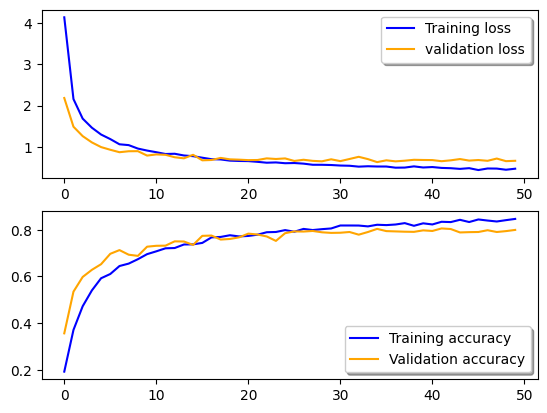

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='orange', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)


ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='orange',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Learning Curves - Graphs

50/50 [==============================] - 2s 20ms/step


<Axes: >

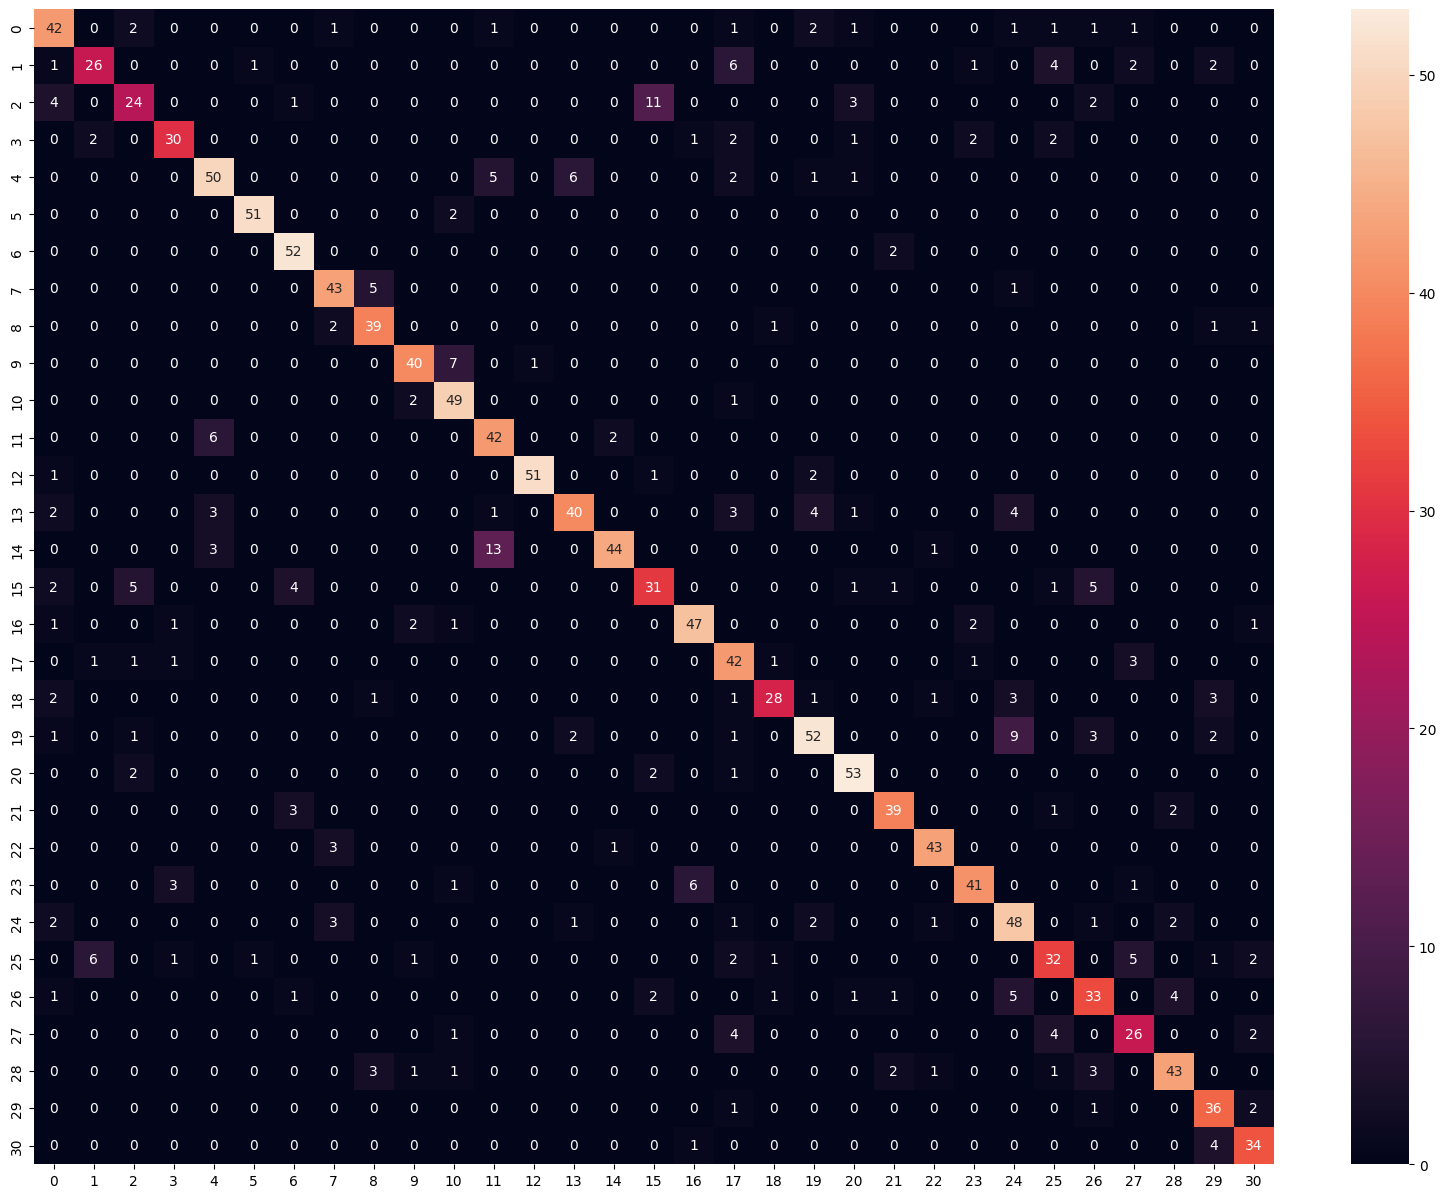

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# # Get the true labels by iterating over the validation generator
# val_labels = []
# for i in range(len(val_generator)):
#     _, labels = val_generator[i]
#     val_labels.extend(np.argmax(labels, axis=1))

# Get the predicted labels using the trained model
Y_pred = resnet_model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
targets = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cf_mat = confusion_matrix(targets, y_pred)

plt.figure(figsize=(20,15))

# plot the confusion matrix
sns.heatmap(cf_mat, annot=True, fmt="d")
# cf_mat_normalized = cf_mat.astype('float') / cf_mat.sum(axis=1)[:, np.newaxis]

In [ ]:
np.save(data_dir + 'resnet50_cm_5.npy', cf_mat)
np.save(data_dir + 'resnet50_targets_5.npy', targets)
np.save(data_dir + 'resnet50_preds_5.npy', y_pred)

In [ ]:
print("Accuracy of the model is - " , resnet_model.evaluate(x_test,y_test)[1]*100 , "%")

50/50 [==============================] - 1s 22ms/step - loss: 0.6996 - accuracy: 0.7958
Accuracy of the model is -  79.58015203475952 %


In [ ]:
print(classification_report(targets, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74        54
           1       0.74      0.60      0.67        43
           2       0.69      0.53      0.60        45
           3       0.83      0.75      0.79        40
           4       0.81      0.77      0.79        65
           5       0.96      0.96      0.96        53
           6       0.85      0.96      0.90        54
           7       0.83      0.88      0.85        49
           8       0.81      0.89      0.85        44
           9       0.87      0.83      0.85        48
          10       0.79      0.94      0.86        52
          11       0.68      0.84      0.75        50
          12       0.98      0.93      0.95        55
          13       0.82      0.69      0.75        58
          14       0.94      0.72      0.81        61
          15       0.66      0.62      0.64        50
          16       0.85      0.85      0.85        55
          17       0.62    

### Predict Images 

In [ ]:
#Creating a dictionary to map each of the indexes to the corresponding number or letter
from keras.preprocessing import image
dict = {0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G",7:"H",8:"I",9:"J",10:"K",
        11:"L",12:"M",13:"N",14:"O",15:"P",16:"Q",17:"R",18:"S",19:"T",20:"U",21:"V",22:"W",23:"X",
        24:"Y",25:"Z"}


#Predicting images

img = image.load_img("sign_B2.jpg", target_size=(180, 180))
x = image.img_to_array(img)
plt.imshow(img)
x = np.expand_dims(x, axis=0)

image = np.vstack([x])
classes = resnet_model.predict(image, batch_size=64)
label = [np.argmax(i) for i in classes]
pred_class=[dict[x] for x in label]
pred_class

### Evaluating the Model 

_Plotting the Confusion Matrix_


In [ ]:
Y_pred = resnet_model.predict_generator(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
cf_mat = confusion_matrix(val_generator.classes, y_pred)
cf_mat_normalized = cf_mat.astype('float') / cf_mat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(7, 6))
sns.heatmap(cf_mat_normalized, cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')

_Printing the Classification Report_

In [ ]:
labels = val_generator.classes

In [ ]:
print(classification_report(targets, y_pred))

_Evalutation Metrics on Test Set_

In [ ]:
loss, accuracy, f1_score, precision, recall = resnet_model.evaluate(val_ds, verbose=0)

In [ ]:
print(f"Test Loss: ", round(loss*100, 3), '%')
print(f"Test Accuracy: ", round(accuracy*100, 3), '%')
print(f"Test Precision: ", round(precision*100, 3), '%')
print(f"Test Recall: ",round(recall*100, 3), '%')
print(f"Test F1 Score: ",round(f1_score*100, 3), '%')